# Rekomendasi Buku

Dataset diperoleh dari sumber yang tersedia secara open-source, dapat dilihat di tautan dibawah ini

Dataset : https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

## Data Loading

Disini saya menggunakan file zip yang disimpan di Google Drive pribadi saya. Anda dapat menggunakan cara dibawah ini untuk menghubungkan Drive dengan Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Setelah file Drive terhubung dengan Colab, kita bisa unzip file dataset kita.

In [ ]:
!unzip gdrive/My\ Drive/Project_ML/Book_Recom.zip

Archive:  gdrive/My Drive/Project_ML/Book_Recom.zip
  inflating: Books.csv               
  inflating: Ratings.csv             
  inflating: Users.csv               


Terdapat 3 file di dalam zip dan karena file dataset dalam format .csv, kita dapat menggunakan library pandas untuk membaca file tersebut dan melihat beberapa sampel data.

In [ ]:
data = pd.read_csv('Books.csv')
rating = pd.read_csv('Ratings.csv')
user = pd.read_csv('Users.csv')
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


file data berisikan data mengenai buku

In [ ]:
rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


file rating berisikan rating yang diberikan users kepada suatu buku

In [ ]:
user.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


sedangkan file users berisikan data diri user.

In [ ]:
print(data.shape)
print(rating.shape)
print(user.shape)

(271360, 8)
(1149780, 3)
(278858, 3)


Kesimpulannya, Dataset ini terdiri dari 3 file dengan file **Data.csv** (berisikan 271360 jenis buku dengan 8 kolom data masing-masing buku), file **Ratings.csv** (berisikan 1149780 pengguna yang memberikan rating/nilai dengan kolom ID pengguna, ISBN buku dan rating yang diberikan) dan yang terakhir adalah file **Users.csv** (berisikan 278858 data pengguna dengan 3 kolom, ID pengguna, Alamat dan Umur).

## Data Pre-Process & Exploratory Data Analysis (EDA)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB



Semua variabel pada file **Data.csv** ini merupakan _object_ dengan total terdapat 8 variabel dengan deskripsi sebagai berikut:
- ISBN (ID buku)
- Book-Title (Judul buku)
- Book-Author (Penulis buku)
- Year-Of-Publication (Tahun terbit)
- Publisher (Penerbit)
- Image-URL-S (Foto ukuran kecil)
- Image-URL-M (Foto ukuran sedang)
- Image-URL-L (Foto ukuran besar)

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Semua variabel pada file **Ratings.csv** ini terdapat 2 variabel _integer_ dan 1 file _object_ dengan total terdapat 3 variabel dengan deskripsi sebagai berikut:
- User-ID (ID Pengguna)
- ISBN
- Book-Rating (Rating yang diberikan)

In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Semua variabel pada file **Users.csv** ini terdapat 1 variabel _integer_ , 1 variabel _float_ dan 1 file _object_ dengan total terdapat 3 variabel dengan deskripsi sebagai berikut:
- User-ID (ID Pengguna)
- Location (Lokasi daerah pengguna)
- Age (Umur Pengguna)

In [ ]:
data['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

Pada dataset **data.csv** terdapat beberapa data yang tidak masuk akal atau invalid, beberapa tahun berisikan format yang berbeda, bahkan tahun terbit dalam tulisan, seperti 'DK Publishing Inc' dan 'Gallimard'. Selain itu, Terdapat juga angka 0, dan dari masa depan seperti 2024, 2050, dst(project ini dibuat tahun 2022) dan tahun yang agak lama seperti 1376, 1378, dst.

In [ ]:
data = data[~data['Year-Of-Publication'].isin(['DK Publishing Inc', 'Gallimard'])]
data['Year-Of-Publication'] = pd.to_numeric(data['Year-Of-Publication'])
invalid_year = []
for i in data['Year-Of-Publication'].unique():
  if i not in range(1950,2020):
    invalid_year.append(i)
for y in invalid_year:
  index_names = data[data['Year-Of-Publication'] == y].index
  data.drop(index_names, inplace = True)
data['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1970, 1962, 1973, 1972, 1960, 1966, 1956,
       1959, 1953, 1951, 1963, 1964, 1969, 1954, 1950, 1967, 2005, 1957,
       1955, 2011, 2010, 2012, 2006, 2008])

Kita hanya mengambil data dari tahun 1950 hingga 2020 untuk menjaga kebersihan data dan dikarenakan data yang di drop tidak banyak diluar dari tahun tersebut.

In [ ]:
print(data.shape)

(266429, 8)


Pada awalnya terdapat 271360 buku pada dataset **Data.csv**, dan terdapat 4931 data yang memiliki tahun terbit tidak valid dan telah dihapus sehingga data tersisa 266429 baris data buku.

In [ ]:
data['Year-Of-Publication'].value_counts()

2002    17627
1999    17431
2001    17359
2000    17232
1998    15766
        ...  
2006        3
2011        2
2010        2
2012        1
2008        1
Name: Year-Of-Publication, Length: 61, dtype: int64

Terdapat 61 tahun pada kolom tahun penerbitan dengan penerbitan paling banyak pada tahun 2002.

No handles with labels found to put in legend.


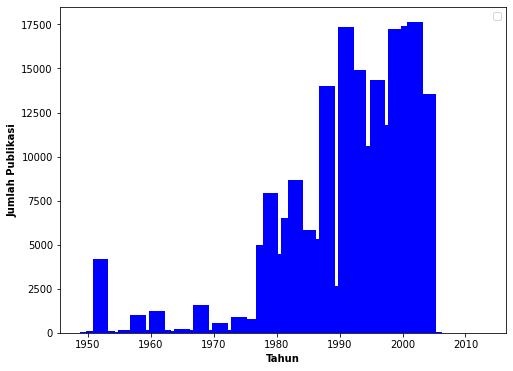

In [ ]:
fig = plt.subplots(figsize =(8, 6))
plt.bar(data['Year-Of-Publication'].unique(), data['Year-Of-Publication'].value_counts(), color ='b', width = 2.5)
plt.xlabel('Tahun', fontweight ='bold', fontsize = 10)
plt.ylabel('Jumlah Publikasi', fontweight ='bold', fontsize = 10)
plt.legend()
plt.show()

Terlihat pada data ini publikasi yang tercatat pada dataset ini mulai banyak di sekitar tahun 1980 hingga sekitar tahun 2005.

In [ ]:
data['Book-Title'].value_counts()

Selected Poems                                                                                                                    27
Little Women                                                                                                                      22
Wuthering Heights                                                                                                                 20
Adventures of Huckleberry Finn                                                                                                    20
Dracula                                                                                                                           20
                                                                                                                                  ..
Starlight and Storm (Modern Library Exploration Series)                                                                            1
About Town : The New Yorker and The World It Made                    

Pada informasi diatas, terlihat bahwa ada beberapa data judul buku yang terduplikat, maka dari itu harus di buang karena memiliki indikasi data yang tidak valid.

In [ ]:
data = data.drop_duplicates(subset=['Book-Title'])
data['Book-Title'].value_counts()

Classical Mythology                                                                                                               1
Marriage Diamond Style (Harlequin Desire No 679)                                                                                  1
Great White Fathers: The Story of the Obsessive Quest to Create Mount Rushmore                                                    1
Das Fest des Ziegenbocks.                                                                                                         1
Die falsche Sanftmut des Schnees.                                                                                                 1
                                                                                                                                 ..
Co-Op                                                                                                                             1
Perfect Match (Avon Light Contemporary Romances)                            

Setelah menghapus buku yang duplikat, akan lebih baik kita juga mengecek kolom ISBN.

In [ ]:
data['ISBN'].value_counts()

0195153448    1
0373056796    1
1891620983    1
3518399276    1
3596137454    1
             ..
0373970374    1
0380813068    1
0849937345    1
0448422913    1
0767409752    1
Name: ISBN, Length: 238261, dtype: int64

Terlihat pada dataset **Users.csv** bahwa ada beberapa kolom "Age" atau umur yang hilang.

In [ ]:
user['Age'].isna().sum()

110762

Terdapat 110762 data umur yang hilang, data tersebut akan kita drop setelah kita menggabungkan dataset dengan **Rating.csv**.

In [ ]:
user_rating = pd.merge(rating, user, on='User-ID')
user_rating

,User-ID,ISBN,Book-Rating,Location,Age
0,276725,034545104X,0,"tyler, texas, usa",NaN
1,276726,0155061224,5,"seattle, washington, usa",NaN
2,276727,0446520802,0,"h, new south wales, australia",16.0
3,276729,052165615X,3,"rijeka, n/a, croatia",16.0
4,276729,0521795028,6,"rijeka, n/a, croatia",16.0
...,...,...,...,...,...
1149775,276704,1563526298,9,"cedar park, texas, usa",NaN
1149776,276706,0679447156,0,"quebec, quebec, canada",18.0
1149777,276709,0515107662,10,"mannington, west virginia, usa",38.0
1149778,276721,0590442449,10,"providence, rhode island, usa",14.0


Setelah digabungkan dengan **Ratings.csv**, terdapat 1149780 data.

In [ ]:
UR_drop = user_rating.dropna()
UR_drop.shape

(840288, 5)

Dari 1149780 data, setelah dihapus nilai hilang pada kolom umur, pada dataset masih tersisa 840288 data.

Setelah itu, kita juga perlu tau berapa statistik rating yang diberikan oleh pengguna.

In [ ]:
UR_drop['Book-Rating'].value_counts()

0     535011
8      73392
10     59577
7      52514
9      50363
5      31572
6      25136
4       5960
3       3911
2       1801
1       1051
Name: Book-Rating, dtype: int64

Pada data dan grafik diatas, banyak sekali yang memberikan rating 0 terhadap sebuah buku, terdapat keanehan disini. Disini kita akan menghapus semua data rating yang bernilai 0 dan menganggap rentang nilai rating adalah 1-10.

In [ ]:
index_names = UR_drop[UR_drop['Book-Rating'] == 0].index
UR_drop.drop(index_names, inplace = True)
UR_drop

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,User-ID,ISBN,Book-Rating,Location,Age
3,276729,052165615X,3,"rijeka, n/a, croatia",16.0
4,276729,0521795028,6,"rijeka, n/a, croatia",16.0
7,276737,0600570967,6,"sydney, new south wales, australia",14.0
9,276745,342310538,10,"berlin, berlin, germany",27.0
16,276747,0060517794,9,"iowa city, iowa, usa",25.0
...,...,...,...,...,...
1149649,276681,0609806491,7,"chicago, illinois, usa",43.0
1149651,276681,1931333246,10,"chicago, illinois, usa",43.0
1149777,276709,0515107662,10,"mannington, west virginia, usa",38.0
1149778,276721,0590442449,10,"providence, rhode island, usa",14.0


Setelah dihapus, masih tersisa 305277 jumlah data, hal ini masih berlebihan untuk program kita mengingat terdapat keterbatasan dalam memproses data yang sebegitu banyak.

No handles with labels found to put in legend.


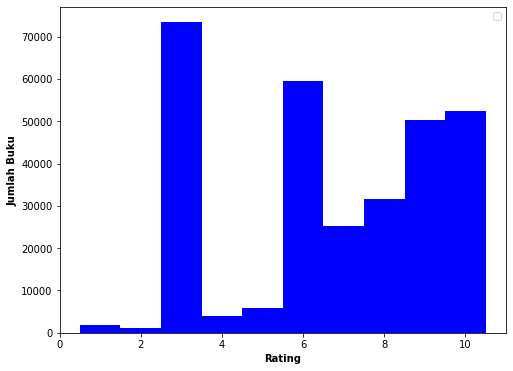

In [ ]:
fig = plt.subplots(figsize =(8, 6))
plt.bar(UR_drop['Book-Rating'].unique(), UR_drop['Book-Rating'].value_counts(), color ='b', width = 1)
plt.xlabel('Rating', fontweight ='bold', fontsize = 10)
plt.ylabel('Jumlah Buku', fontweight ='bold', fontsize = 10)
plt.legend()
plt.show()

Terlihat data rating tidak terlalu seimbang, terdapat banyak nilai angka 3 dibandingkan dengan 1,2,4 dan 5.

In [ ]:
all = pd.merge(UR_drop, data, on='ISBN')
all = all.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'])
all.dropna()
all

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276729,052165615X,3,"rijeka, n/a, croatia",16.0,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
1,276729,0521795028,6,"rijeka, n/a, croatia",16.0,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press
2,276747,0060517794,9,"iowa city, iowa, usa",25.0,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch
3,278843,0060517794,7,"pismo beach, california, usa",28.0,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch
4,4017,0060517794,10,"new orleans, louisiana, usa",48.0,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch
...,...,...,...,...,...,...,...,...,...
228085,276681,014006284X,10,"chicago, illinois, usa",43.0,Portrait of the Artist as a Young Man,James Joyce,1982,Penguin Books
228086,276681,0140195246,7,"chicago, illinois, usa",43.0,How to Find the Work You Love (Arkana S.),Laurence G. Boldt,1996,Penguin Books
228087,276681,0140290788,9,"chicago, illinois, usa",43.0,Time Out Chicago (Time Out Chicago),Time Out,2000,Penguin Books
228088,276681,0609806491,7,"chicago, illinois, usa",43.0,The Zen of Proposal Writing: An Expert's Stres...,Kitta Reeds,2002,Three Rivers Press (CA)


Kemudian menggabungkan ketiga dataset yang sebelumnya sudah di proses dengan acuan kolom "ISBN" dan juga untuk ketiga kolom link gambar tidak akan digunakan pada proyek ini.

In [ ]:
all.describe()

,User-ID,Book-Rating,Age,Year-Of-Publication
count,228090.000000,228090.000000,228090.000000,228090.000000
mean,137432.769192,7.729822,36.751914,1995.795458
std,79262.918177,1.819271,13.709274,7.129802
min,19.000000,1.000000,0.000000,1950.000000
25%,70594.000000,7.000000,28.000000,1993.000000
50%,134294.000000,8.000000,35.000000,1998.000000
75%,206202.000000,9.000000,45.000000,2001.000000
max,278851.000000,10.000000,244.000000,2006.000000


Pelu untuk dipastikan sekali lagi persebaran data pada dataframe lengkap kita untuk memastikan data bersih. Terlihat bahwa kolom umur memiliki rentang dari 0 hingga 244. Hal ini cukup aneh dimana anak kecil berumur 0 tahun tidak mungkin bisa membaca buku dan manusia tidak mungkin mencapai umur 244 tahun. jadi kita perlu mengambil data umur dalam rentang 10 hingga 100 tahun saja.

In [ ]:
all = all[(all['Age']<=100)&(all['Age']>=10)]
all.describe()

,User-ID,Book-Rating,Age,Year-Of-Publication
count,226079.000000,226079.000000,226079.000000,226079.000000
mean,137234.302036,7.731979,36.672269,1995.804714
std,79178.248045,1.818289,12.212859,7.118668
min,19.000000,1.000000,10.000000,1950.000000
25%,70415.000000,7.000000,28.000000,1993.000000
50%,133772.000000,8.000000,35.000000,1998.000000
75%,205943.000000,9.000000,45.000000,2001.000000
max,278851.000000,10.000000,100.000000,2006.000000


Setelah dipastikan kembali, persebaran data sudah bersih pada semua data.

In [ ]:
all

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276729,052165615X,3,"rijeka, n/a, croatia",16.0,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
1,276729,0521795028,6,"rijeka, n/a, croatia",16.0,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press
2,276747,0060517794,9,"iowa city, iowa, usa",25.0,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch
3,278843,0060517794,7,"pismo beach, california, usa",28.0,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch
4,4017,0060517794,10,"new orleans, louisiana, usa",48.0,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch
...,...,...,...,...,...,...,...,...,...
228085,276681,014006284X,10,"chicago, illinois, usa",43.0,Portrait of the Artist as a Young Man,James Joyce,1982,Penguin Books
228086,276681,0140195246,7,"chicago, illinois, usa",43.0,How to Find the Work You Love (Arkana S.),Laurence G. Boldt,1996,Penguin Books
228087,276681,0140290788,9,"chicago, illinois, usa",43.0,Time Out Chicago (Time Out Chicago),Time Out,2000,Penguin Books
228088,276681,0609806491,7,"chicago, illinois, usa",43.0,The Zen of Proposal Writing: An Expert's Stres...,Kitta Reeds,2002,Three Rivers Press (CA)


Setelah dataset bersih, kita bisa lanjutkan ke proses filtering.

## Content Based Filtering

### Data Preparation

Pada content-base filtering, kita perlu menyiapkan dataset dengan kolom kode buku(ISBN), judul buku dan pengarang sebagai acuan filtering.

In [ ]:
isbn = all['ISBN'].tolist()
book = all['Book-Title'].tolist()
author = all['Book-Author'].tolist()

cont = pd.DataFrame({'ISBN': isbn, 'Title': book,'Author': author})
cont = cont.drop_duplicates(subset=['ISBN'])
cont = cont.dropna()
cont

,ISBN,Title,Author
0,052165615X,Help!: Level 1,Philip Prowse
1,0521795028,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather
2,0060517794,Little Altars Everywhere,Rebecca Wells
26,0671537458,Waiting to Exhale,Terry McMillan
40,0679776818,Birdsong: A Novel of Love and War,Sebastian Faulks
...,...,...,...
226074,014006284X,Portrait of the Artist as a Young Man,James Joyce
226075,0140195246,How to Find the Work You Love (Arkana S.),Laurence G. Boldt
226076,0140290788,Time Out Chicago (Time Out Chicago),Time Out
226077,0609806491,The Zen of Proposal Writing: An Expert's Stres...,Kitta Reeds


Kita juga perlu menghapus data ISBN yang duplikat dan nilai kosong/hilang. Hasilnya, kita mendapat 103275 data.

In [ ]:
cont['Author'].value_counts()

William Shakespeare    291
Agatha Christie        234
Stephen King           223
Nora Roberts           195
Terry Pratchett        166
                      ... 
Leslie Epstein           1
TONY COHAN               1
Jill Baker               1
John Antal               1
Kurt Messick             1
Name: Author, Length: 48100, dtype: int64

Setelah diperiksa, masing-masing penulis memiliki rentang 1 hingga 291 judul buku pada dataset. Mengingat kita akan merekomendasikan 10 buku dari sebuah buku, maka penulis yang memiliki kurang dari 11 buku pada dataset tidak dapat menampilkan hasil yang memuaskan. Selain itu, untuk memproses data sebanyak itu dibutuhkan biaya komputasi yang mahal dan dapat menyebabkan error jika dijalankan pada hardware yang kurang mumpuni. Maka dari itu, pada proyek ini ditentukan jumlah buku yang dimiliki tiap penulis pada dataset ini adalah minimal 16.

In [ ]:
counts=cont['Author'].value_counts()
content = cont[~cont['Author'].isin(counts[counts <= 15].index)]
content['Author'].value_counts()

William Shakespeare               291
Agatha Christie                   234
Stephen King                      223
Nora Roberts                      195
Terry Pratchett                   166
                                 ... 
Dashiell Hammett                   16
John Ronald Reuel Tolkien          16
John Gardner                       16
Vladimir Vladimirovich Nabokov     16
Peggy Parish                       16
Name: Author, Length: 654, dtype: int64

Total terdapat 654 nama penulis/author yang diambil dari 48100.

In [ ]:
content

,ISBN,Title,Author
56,0684867621,The Girl Who Loved Tom Gordon : A Novel,Stephen King
103,0451166892,The Pillars of the Earth,Ken Follett
167,0380711524,See Jane Run,Joy Fielding
178,3453092007,Die zweite Haut.,Dean Koontz
186,0330332775,Bridget Jones's Diary,Helen Fielding
...,...,...,...
226013,0307010082,What's Up in the Attic? (Little Golden Book),Golden Books
226021,0590473026,Working Hard With the Mighty Loader,Justine Korman
226046,1572703164,The Sittaford Mystery (Mystery Masters Series),Agatha Christie
226048,0380799685,David Brin's Out of Time: Yanked! (David Brin'...,Nancy Kress


Dan memiliki total 20725 data. Jumlah ini sudah sangat memakan banyak biaya komputasional.

### Filtering Process

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer()
tfidf_matrix = tfid.fit_transform(content['Author'])
tfidf_matrix.shape

(20725, 990)

Pada Proses ini digunakan TF-IDF sebagai proses _feature extraxtion_. Pertama, kita perlu tokenisasi author menggunakan fit sekaligus transformasi. Kita akan membangun sistem rekomendasi berdasarkan nama pengarang. Hal itu dikarenakan beberapa gaya penulisan akan unik masing-masing pengarang, selain itu, kekurangan data kategori pada dataset membuat pengarang menjadi variabel yang cocok untuk dijadikan patokan untuk rekomendasi sebuah buku.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim, index=content['Title'], columns=content['Title'])
print('Shape:', cosine_sim_df.shape)

Shape: (20725, 20725)


Dari tokenisasi diatas kita dapat menentukan jarak antar data judul dengan metrik cosine similarity. Setelah itu, hasil dari jarak tiap judul dijadikan dataframe agar bisa diproses untuk menampilkan rekomendasi selanjutnya.

In [ ]:
def book_recommendations(nama_buku, similarity_data=cosine_sim_df, items=content[['Title', 'Author']], k=10):

    index = similarity_data.loc[:,nama_buku].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(nama_buku, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

untuk fungsi **book_recommendations** sendiri menggunakan parameter nama buku, dataframe dari cosine similarity, dataframe item yang berisi kolom 'Title' dan 'Author' dengan jumlah _neighbour_ 10. Pertama data diambil berdasarkan index dengan argpartition, kemudian index yang diambil diurutkan dari yang terbesar nilai cosine similarity-nya. Lalu tentu saja baris nama buku yang menjaid variabel akan dihapus. Kemudian untuk _return_ nya sendiri adalah dataframe dengan kolom index, title dan author dan diambil 10 data dengan cosine similarity tertinggi.

In [ ]:
choose = input("Masukkan judul buku yang dipilih: ")
x = book_recommendations(choose)
x

Masukkan judul buku yang dipilih: See Jane Run


,Title,Author
0,Don't Cry Now,Joy Fielding
1,Tell Me No Secrets,Joy Fielding
2,"Lauf, Jane, lauf. Roman.",Joy Fielding
3,Whispers and Lies,Joy Fielding
4,The Deep End,Joy Fielding
5,"Flieh, wenn du kannst.",Joy Fielding
6,Sag Mammi goodbye.,Joy Fielding
7,Schau Dich nicht um.,Joy Fielding
8,Life Penalty,Joy Fielding
9,"Lauf, Jane, lauf.",Joy Fielding


Berikut sebagai contoh, kita ingin memberikan rekomendasi kepada orang yang membaca buku berjudul "See Jane Run"

In [ ]:
choose_author = content[content['Title'] == choose]
choose_author = choose_author.iloc[0, 2]
# print(choose_author)
eval = 0
result = [x for x in x['Author']]
for i in result:
  if i == choose_author:
    eval += 1
eval = eval/10*100
print('Akurasi yang diberikan :{}%'.format(eval))

Akurasi yang diberikan :100.0%


Dikarenakan pada dataset kita telah mengambil author dengan jumlah buku minimal 16, maka seharusnya rekomendasi dapat menampilkan 10 rekomendasi sesuai authornya.

## Collaborative Filtering

### Data Preparation

Sama halnya dengan Content-Based Filtering, pada collaborative filtering juga membutuhkan dataset dengan kolom tertentu. Disini diambil ID pengguna, ID buku/ISBN, judul buku dan rating pengguna.

In [ ]:
UID = all['User-ID'].tolist()
ISBN = all['ISBN'].tolist()
title = all['Book-Title'].tolist()
rate = all['Book-Rating'].tolist()

collab = pd.DataFrame({
    'UID': UID,
    'ISBN': ISBN,
    'Title': title,
    'Rating': rate
})
collab

,UID,ISBN,Title,Rating
0,276729,052165615X,Help!: Level 1,3
1,276729,0521795028,The Amsterdam Connection : Level 4 (Cambridge ...,6
2,276747,0060517794,Little Altars Everywhere,9
3,278843,0060517794,Little Altars Everywhere,7
4,4017,0060517794,Little Altars Everywhere,10
...,...,...,...,...
226074,276681,014006284X,Portrait of the Artist as a Young Man,10
226075,276681,0140195246,How to Find the Work You Love (Arkana S.),7
226076,276681,0140290788,Time Out Chicago (Time Out Chicago),9
226077,276681,0609806491,The Zen of Proposal Writing: An Expert's Stres...,7


Terdapat 226079, sama seperti sebelumnya, data ini adalah data yang sangat amat berat biaya komputasionalnya. maka dari itu, akan di hapus beberapa data.

In [ ]:
collab = collab.sample(frac=1, random_state=42).reset_index(drop=True)
dropped_index = []
for i in range (0,200000):
  dropped_index.append(i)

collab = collab.drop(dropped_index)
collab = collab.reset_index(drop=True)
collab

,UID,ISBN,Title,Rating
0,184465,0201616467,Practical Java(TM) Programming Language Guide,8
1,235105,0425144372,Clear and Present Danger,8
2,163467,038079540X,This One and Magic Life : A Novel of a Souther...,7
3,101632,0440131480,Breakfast of Champions,9
4,185233,0893755818,Wonders of the Seasons,5
...,...,...,...,...
26074,196160,0441359175,I Will Fear No Evil,8
26075,257532,0812523016,Dracula (Tor Classics),10
26076,60244,0865476276,Stolen Figs: And Other Adventures in Calabria,8
26077,79754,0451404211,The Woman Who Married a Bear,5


Setelah diacak dan dihapus 200000 data, kini tersisa 26079 data yang sekiranya dapat diproses jika dijalankan di Google Colab biasa.

### Filtering Process

Terdapat 2 proses filtering yang akan kita gunakan kali ini, yaitu Memory-based dengan cara Item-based dan Model-based dengan cara deep learning.

#### Item-based Collaborative Filtering

Untuk Item-based, kita perlu mengubah dataframe menjadi pivot table dengan index judul buku, kolom ID Pengguna dan nilai berupa rating.

In [ ]:
collab_rate = collab.drop_duplicates(['UID', 'ISBN', 'Title'])
collab_rate_pivot = collab_rate.pivot(index = 'Title', columns = 'UID', values = 'Rating').fillna(0)
collab_rate_pivot

UID,75,114,176,242,254,334,362,367,388,392,...,278376,278390,278422,278492,278552,278554,278668,278832,278843,278844
Title,,,,,,,,,,,,,,,,,,,,,
Murder of a Sleeping Beauty (Scumble River Mysteries (Paperback)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nonbook Materials: The Organization of Integrated Collections,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"The Secret of the Old Clock (Nancy Drew, Book 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
This Place Has No Atmosphere (Laurel-Leaf Books),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Travel Companion Chile and Easter Island (Travel Companion),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
it was today,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
stardust,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Â¿QuiÃ©n se ha llevado mi queso?,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Total didapatkan pivot table dengan dimensi 19356x10407. Kemudian perlu mengubah menjadi CSR (Compressed Sparse Row) Matrix agar komputasi berikutnya lebih efisien.

In [ ]:
collab_matrix = csr_matrix(collab_rate_pivot.values)
collab_matrix

<19356x10407 sparse matrix of type '<class 'numpy.float64'>'
	with 26079 stored elements in Compressed Sparse Row format>

Setelah diubah, kita akan memasukkan data tersebut ke dalam model KNN dengan metric cosine dan algorithm brute.

In [ ]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(collab_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

Setelah mendapat model, kita dapat menentukan salah satu buku untuk dilihat rekomendasi buku-buku yang mirip dengan satu buku tersebut. Kemudian dihitung jaraknya dan indexnya dengan jumlah neighbour 6 (mengambil 6 buku dengan jarak terdekat termasuk diri sendiri).

In [ ]:
query_index = np.random.choice(collab_rate_pivot.shape[0])
print('Memberikan rekomendasi dari buku : "{}"'.format(collab_rate_pivot.index[query_index]))
distances, indices = model_knn.kneighbors(collab_rate_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

Memberikan rekomendasi dari buku : "OUT OF THE WOODS : Stories"


Kemudian index pertama atau 0 akan menjadi bukuitu sendiri dan sisanya akan menjadi buku yang memiliki jarak terdekat.

In [ ]:
jarak = []
for i in range(0, len(distances.flatten())):
  if i == 0:
    print('Rekomendasi dari buku "{0}":\n'.format(collab_rate_pivot.index[query_index]))
  else:
    print('{0}: {1}, Dengan jarak {2}:'.format(i, collab_rate_pivot.index[indices.flatten()[i]], distances.flatten()[i]))
    jarak.append(distances.flatten()[i])

Rekomendasi dari buku "OUT OF THE WOODS : Stories":

1: OUT OF THE WOODS : Stories, Dengan jarak 0.0:
2: GARDEN OF EDEN, Dengan jarak 0.0:
3: An Unquiet Mind, Dengan jarak 0.29289321881345254:
4: Songs of the Humpback Whale : A Novel in Five Voices, Dengan jarak 1.0:
5: Songs of Innocence and Songs of Experience (Dover Thrift Editions), Dengan jarak 1.0:


In [ ]:
mean = sum(jarak)/len(jarak)
print('Total rata-rata jarak pada rekomendasi adalah : {}'.format(mean))

Total rata-rata jarak pada rekomendasi adalah : 0.45857864376269053


#### Model-based Collaborative Filtering

Sedangkan untuk Model-based, kita perlu meng-encoding ID pengguna dan IB buku/ISBN mengingat data tersebut memiliki persebaran yang sembarang dan akan menyebabkan model sulit menghasilkan prediksi yang baik.

In [ ]:
user_ids = collab['UID'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke UID: ', user_encoded_to_user)

encoded angka ke UID:  {0: 184465, 1: 235105, 2: 163467, 3: 101632, 4: 185233, 5: 236267, 6: 99792, 7: 264637, 8: 138198, 9: 148199, 10: 44647, 11: 16916, 12: 94772, 13: 115224, 14: 264082, 15: 22981, 16: 201684, 17: 206932, 18: 147451, 19: 274301, 20: 246247, 21: 137627, 22: 34767, 23: 10697, 24: 100578, 25: 90358, 26: 98391, 27: 60337, 28: 153869, 29: 182345, 30: 151946, 31: 89551, 32: 94951, 33: 267538, 34: 129716, 35: 165503, 36: 193502, 37: 273113, 38: 173415, 39: 179978, 40: 264124, 41: 224944, 42: 33145, 43: 69156, 44: 111847, 45: 145619, 46: 161265, 47: 101209, 48: 38660, 49: 49155, 50: 136419, 51: 207825, 52: 232945, 53: 5489, 54: 80202, 55: 250948, 56: 20180, 57: 274363, 58: 1928, 59: 202711, 60: 28634, 61: 3605, 62: 187145, 63: 21252, 64: 32122, 65: 160712, 66: 119594, 67: 92547, 68: 27383, 69: 197659, 70: 74215, 71: 126765, 72: 123597, 73: 170742, 74: 160735, 75: 238390, 76: 95902, 77: 263504, 78: 35836, 79: 54528, 80: 228789, 81: 36836, 82: 157284, 83: 26756, 84: 123883, 8

encoding yang dilakukan secara manual dengan memberikan nilai mulai dari 1 hingga jumlah panjang data, kemudian pasangan key dan value dibalik agar bisa dimasukkan ke dalam dataset baru nantinya. Tentu saja, untuk proses encoding antara ID pengguna dan ISBN memiliki cara yang sama.

In [ ]:
book_ids = collab['ISBN'].unique().tolist()
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}
print('encoded angka ke ISBN: ', book_encoded_to_book)

encoded angka ke ISBN:  {0: '0201616467', 1: '0425144372', 2: '038079540X', 3: '0440131480', 4: '0893755818', 5: '1566191920', 6: '0385496745', 7: '0671000403', 8: '0802135412', 9: '0226104036', 10: '0553564528', 11: '067084439X', 12: '037542217X', 13: '1400032717', 14: '0451176928', 15: '0816724199', 16: '0460873202', 17: '0765341174', 18: '8401009421', 19: '0385509553', 20: '0839828268', 21: '0553351397', 22: '0139210652', 23: '0446530522', 24: '0140378278', 25: '0192835211', 26: '1576832996', 27: '0380811065', 28: '0821620045', 29: '3442416582', 30: '3499263882', 31: '0821754408', 32: '0140340203', 33: '0671013971', 34: '1562450549', 35: '0802114369', 36: '0262680025', 37: '0441010229', 38: '0373484887', 39: '0671528904', 40: '0689823517', 41: '0140309578', 42: '0385260156', 43: '2841564339', 44: '0441011349', 45: '0449227944', 46: '0671737821', 47: '0679776877', 48: '0800716426', 49: '0806519274', 50: '8401490693', 51: '1573229725', 52: '0671751506', 53: '0440241073', 54: '01400691

Setelah selesai di encoding, nilai hasil encoding tiap data perlu untuk dimasukkan ke dalam dataframe dan diacak dataframenya.

In [ ]:
collab['user'] = collab['UID'].map(user_to_user_encoded)
collab['book'] = collab['ISBN'].map(book_to_book_encoded)

collab_model = collab.sample(frac=1, random_state=42)
collab_model

,UID,ISBN,Title,Rating,user,book
1441,105535,0385471998,Come As You Are: The Story of Nirvana,5,1150,1384
2464,157655,0061099015,The Great and Secret Show,8,1843,2321
3023,151503,0679824243,"Mummies in the Morning (Magic Tree House, Book 3)",5,761,2819
22616,244657,0452264790,Tar Baby,8,5085,17150
20661,101851,4789000680,Speaking and Living in Japan (Nihongo Notes),9,125,15857
...,...,...,...,...,...,...
21575,154529,0385501188,Code Sixty-One: A Novel,8,1880,16456
5390,194600,0380730138,Vinegar Hill (Oprah's Book Club (Paperback)),7,216,4595
860,45564,0385720726,You Are Not a Stranger Here : Stories,5,735,839
15795,253386,0345435028,What We Keep,9,2930,12594


Setelah itu, kita perlu menentukan x dan y untuk dimasukan kedalam model. variabel x merupakan gabungan antara ID pengguna dan ID buku yang telah di encoding, sedangkan variabel y merupakan rating yang terlah distandarisasi dengan lambda layer. Kemudian membagi antara Train set dan Validation set dengan rasio sebanyak 80%:20%

In [ ]:
num_users = len(user_to_user_encoded)
num_book = len(book_encoded_to_book)

min_rating = min(collab_model['Rating'])
max_rating = max(collab_model['Rating'])

x = collab_model[['user', 'book']].values
y = collab_model['Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * collab_model.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 1150  1384]
 [ 1843  2321]
 [  761  2819]
 ...
 [  735   839]
 [ 2930 12594]
 [  257  1443]] [0.44444444 0.77777778 0.44444444 ... 0.44444444 0.88888889 0.77777778]


Kemudian kita dapat membangun modelnya. Pada proyek ini, referensi model dapat dilihat pada link berikut:
https://keras.io/examples/structured_data/collaborative_filtering_movielens/

In [ ]:
class RecommenderNet(tf.keras.Model):

  def __init__(self, num_users, num_book, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_book = num_book
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.book_embedding = layers.Embedding(
        num_book,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.book_bias = layers.Embedding(num_book, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    book_vector = self.book_embedding(inputs[:, 1])
    book_bias = self.book_bias(inputs[:, 1])

    dot_user_book = tf.tensordot(user_vector, book_vector, 2)

    x = dot_user_book + user_bias + book_bias

    return tf.nn.sigmoid(x)

Kemudian model di-inisialisasi dengan jumlah embedding sebanyak 50. Untuk lossnya sendiri menggunakan BinaryCrossentropy dan optimizers Adam dengan learning rate 0.001. Sedangkan untuk metrik evaluasi sendiri disini digunakan MAE karena metrik ini sangat bagus untuk digunakan pada data yang tidak seimbang dan kemungkinan memiliki outliers.

In [ ]:
model = RecommenderNet(num_users, num_book, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

Model dilatih dengan batch size sebanyak 8 dan epochs 20.

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 20,
    validation_data = (x_val, y_val)
)

Epoch 1/20
2608/2608 [==============================] - 103s 39ms/step - loss: 0.6795 - mean_absolute_error: 0.2698 - val_loss: 0.6669 - val_mean_absolute_error: 0.2563
Epoch 2/20
2608/2608 [==============================] - 74s 28ms/step - loss: 0.5936 - mean_absolute_error: 0.1938 - val_loss: 0.6553 - val_mean_absolute_error: 0.2452
Epoch 3/20
2608/2608 [==============================] - 74s 28ms/step - loss: 0.5585 - mean_absolute_error: 0.1546 - val_loss: 0.6540 - val_mean_absolute_error: 0.2451
Epoch 4/20
2608/2608 [==============================] - 65s 25ms/step - loss: 0.5505 - mean_absolute_error: 0.1486 - val_loss: 0.6495 - val_mean_absolute_error: 0.2412
Epoch 5/20
2608/2608 [==============================] - 67s 26ms/step - loss: 0.5434 - mean_absolute_error: 0.1412 - val_loss: 0.6463 - val_mean_absolute_error: 0.2384
Epoch 6/20
2608/2608 [==============================] - 66s 25ms/step - loss: 0.5380 - mean_absolute_error: 0.1365 - val_loss: 0.6434 - val_mean_absolute_error

Kemudian nilai evaluasi MAE di plot untuk melihat performa model.

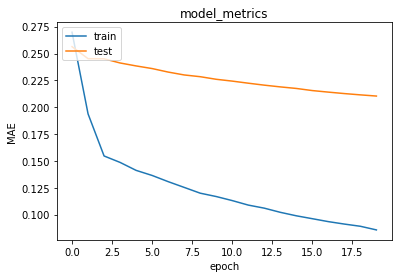

In [ ]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model_metrics')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Terlihat test set kurang baik diakhir karena memiliki jarak nilai MAE yang agak jauh, namun sudah tergolong rendah karena hampir menyentuk 0,2. Selanjutnya, model ini akan digunakan untuk prediksi.

In [ ]:
book_df = cont
df = collab

user_id = df['UID'].sample(1).iloc[0]
book_rated_by_user = df[df['UID'] == user_id]
book_rated_by_user

,UID,ISBN,Title,Rating,user,book
1146,273718,0446390984,Art of Closing Any Deal,3,950,1102
2796,273718,0415124700,Introduction to Theories of Popular Culture,5,950,2613
6889,273718,0786886323,Carter Beats the Devil,8,950,2187
11927,273718,0312156219,Pagan Kennedy's Living: A Handbook for Maturin...,10,950,9841
16672,273718,3822862142,Christy Report,9,950,13208
17251,273718,158898608X,Monstrous: The Autobiography of a Serial Kille...,8,950,13613
22201,273718,1843330644,The Little Book of Buddhist Wisdom (The Little...,10,950,16877
22304,273718,0192815644,Madame Bovary: Life in a Country Town (World's...,10,950,16943


Menggunakan data sebelumnya, dicari sampel 1 ID pengguna dan dilihat buku mana saja yang pernah ia beri rating. Kemudian dicari juga nilai ISBN buku yang tidak pernah ia beri rating yang sekaligus masuk ke proses encoding.

In [ ]:
book_not_rated = book_df[~book_df['ISBN'].isin(book_rated_by_user.ISBN.values)]['ISBN']
book_not_rated = list(set(book_not_rated).intersection(set(book_to_book_encoded.keys())))
book_not_rated = [[book_to_book_encoded.get(x)] for x in book_not_rated]
book_not_rated

[[12729],
 [18728],
 [13659],
 [14234],
 [10984],
 [6129],
 [6502],
 [16131],
 [16611],
 [16955],
 [4386],
 [6269],
 [9205],
 [11032],
 [19194],
 [12222],
 [6444],
 [8733],
 [15166],
 [18312],
 [16944],
 [5558],
 [8999],
 [8527],
 [9695],
 [16821],
 [11940],
 [11437],
 [18893],
 [4493],
 [3414],
 [12872],
 [14430],
 [14061],
 [15578],
 [13325],
 [8372],
 [14165],
 [12587],
 [18397],
 [10978],
 [2055],
 [9455],
 [10147],
 [14969],
 [6476],
 [18421],
 [19254],
 [3075],
 [12595],
 [3740],
 [13154],
 [19181],
 [9628],
 [2991],
 [14012],
 [2701],
 [12773],
 [14862],
 [7842],
 [18516],
 [3653],
 [16178],
 [16525],
 [16785],
 [9255],
 [2381],
 [9941],
 [14186],
 [2316],
 [3578],
 [17548],
 [1234],
 [766],
 [2213],
 [17588],
 [5236],
 [11604],
 [15654],
 [15942],
 [18071],
 [18823],
 [4548],
 [14986],
 [18847],
 [5586],
 [5478],
 [13232],
 [10388],
 [3938],
 [14670],
 [15250],
 [18077],
 [7553],
 [13610],
 [571],
 [10575],
 [7386],
 [4194],
 [17165],
 [18609],
 [13792],
 [9237],
 [3087],
 [625

Kemudian tidak ketinggalan ID pengguna juga di encoding sebelum di prediksi. kemudian menggunakan np.hstack data disusun menjadi format array yang berisikan ID pengguna dan semua ID buku yang tidak dirating pengguna tersebut.

In [ ]:
user_encoder = user_to_user_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_not_rated), book_not_rated)
)
user_book_array

array([[  950, 12729],
       [  950, 18728],
       [  950, 13659],
       ...,
       [  950,  3663],
       [  950,  6770],
       [  950,  7062]])

Kemudian dijalankan predict dan dari semua buku yang belum pengguna tersebut baca, akan diambil 10 nilai y terbesar sebagai buku yang paling direkomendasikan kepada pengguna tersebut. Selain mendapatkan data tersebut, kita juga menampilkan buku yang diberi rating besar oleh pengguna sehingga dapat menjadi perbandingan bila diperlukan.

In [ ]:
ratings = model.predict(user_book_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_book_ids = [
    book_encoded_to_book.get(book_not_rated[x][0]) for x in top_ratings_indices
]

print('Rekomendasi untuk pengguna : {}'.format(user_id))
print('===' * 9)
print('Buku yang disukai pengguna')
print('----' * 8)

top_book_user = (
    book_rated_by_user.sort_values(
        by = 'Rating',
        ascending=False
    )
    .head(5)
    .ISBN.values
)

book_df_rows = book_df[book_df['ISBN'].isin(top_book_user)]
for row in book_df_rows.itertuples():
    print(row.Title)

print('----' * 8)
print('Rekomendasi buku untuk pengguna')
print('----' * 8)

recommended_book = book_df[book_df['ISBN'].isin(recommended_book_ids)]
for row in recommended_book.itertuples():
    print(row.Title)

Rekomendasi untuk pengguna : 273718
Buku yang disukai pengguna
--------------------------------
Carter Beats the Devil
Madame Bovary: Life in a Country Town (World's Classics)
Pagan Kennedy's Living: A Handbook for Maturing Hipsters
The Little Book of Buddhist Wisdom (The Little Book Of...)
Christy Report
--------------------------------
Rekomendasi buku untuk pengguna
--------------------------------
Dragons of Autumn Twilight (Dragonlance Chronicles, Vol 1)
The Fountainhead
The Hobbit : The Enchanting Prelude to The Lord of the Rings
Harry Potter and the Sorcerer's Stone (Book 1)
The Two Towers (The Lord of the Rings, Part 2)
Where the Sidewalk Ends : Poems and Drawings
Hot Six : A Stephanie Plum Novel (A Stephanie Plum Novel)
Lies and the Lying Liars Who Tell Them: A Fair and Balanced Look at the Right
The Return of the King (The Lord of the Rings, Part 3)
Seventh Scroll
